# Bernoulli Regression Model

XXX <br><br>
**Sections**
- [1.0 Synthetic Data & Model](#1.0-Synthetic-Data-&-Model)
- [2.0 Newton Raphson Algorithm](#2.0-Newton-Raphson-Algorithm)
- [3.0 NR Implementation](#3.0-Newton-Raphson-Implementation)
    - [3.1 Checking Convergence](#3.1-Checking-Convergence)
- [4.0 Variance of Estimators](#4.0-Variance-of-Estimators)
    - [4.1 Covariance of $L'(\theta)$](#4.1-Covariance-of-$L'(\theta)$)
    - [4.2 Covariance of $\hat\theta$](#4.2-Covariance-of-$\hat\theta$)

### 0. Importing Modules

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import bokeh
from bokeh.plotting import figure, show
from bokeh.models import tickers, ranges
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

### 1.0 Synthetic Data & Model

- We generate 100 observations
- The model has 3 predictor variables, all generated independently from the standard normal density function.
- True parameters are $\beta_1 =2$, $\beta_2 =0$, $\beta_3 =-1$

\begin{align}
Givens \\ 
\large
b(\theta) & = log(1+e^\theta) \\
\large
p & = \dfrac{e^\theta}{1+e^\theta} \\
\theta & = log \dfrac{p}{1-p} \\
\\
\large
\mu & = b' (\theta) = \dfrac{e^\theta}{1+e^\theta} = p \\
\large
b'' (\theta) & = \dfrac{e^\theta}{(1+e^\theta)^2} = \mu(1-\mu)\\
\\
\large
\eta = x_i \cdot \beta  = g(\mu) & = log \dfrac{\mu}{1-\mu} = log \dfrac{p}{1-p} = \theta 
\end{align}

### 1.1 Generating Synthetic Data

Predictor Variables 

In [2]:
n = 100
xArr = np.random.normal(loc=0.0, scale=1.0, size= (n,3)) 

True Parameters 

In [3]:
b = [2,1,0]
pi = np.exp(xArr @ b) / (1 + np.exp(xArr @ b))
# y is supposed to be random, taking value either 0 or 1.
yi = np.random.binomial(1, pi) # One trial

W Matrix and Var

\begin{align}
\large
W &= (\dfrac{\partial \mu_i}{\partial \eta_i})^2 \dfrac{1}{b''(\theta)} \\
\large
\dfrac{\partial \eta_i}{\partial \mu_i} &= \dfrac{1}{\mu(1-\mu)} \therefore 
\dfrac{\partial \mu_i}{\partial \eta_i} = \mu(1-\mu) \\
\\
\large
W & = (\mu(1-\mu))^2 \dfrac{1}{\mu(1-\mu)} = \mu(1-\mu) = p(1-p) \\
\large
W_i & = \mu_i(1-\mu_i) = p_i(1-p_i) \\
\large
Var_i & = \dfrac{1}{W_i}
\end{align}

In [4]:
def newton_n_iter(xArr, yi, b_0,  tolerance = 0.00001):
    """
    Performs Newton-Raphson root finding.
    
    Args:
        guess (float): initial value for parameter
        tolerance (float): tolerance
    
    """
    #Initialize
    b1 = [b_0[0]]
    b2 = [b_0[1]]
    b3 = [b_0[2]]
    
    difference = tolerance * 5
    iter_number = 0
   
    while abs(difference) > tolerance:
        
        
        pi = np.exp(xArr @ b_0) / (1 + np.exp(xArr @ b_0))
        Wi = np.diag(pi*(1-pi))
        z = xArr @ b_0 + (yi - pi) / (pi*(1-pi))
        beta_1 = np.linalg.inv(xArr.T @ Wi @ xArr) @ xArr.T @ Wi @ z

        b1.append(beta_1[0])
        b2.append(beta_1[1])
        b3.append(beta_1[2])
           
        # calculate difference and update iteration state
        difference = max(abs(np.array(beta_1) - np.array(b_0)))
        b_0 = beta_1
    
        iter_number += 1
    
    return beta_1, b1, b2, b3

In [5]:
beta_1, b1, b2, b3 = newton_n_iter(xArr, yi, [0, 0, 0])

In [6]:
p = figure(toolbar_location= None, outline_line_color = 'black')
p.line(x = range(len(b1)), y = b1, line_width = 1.5, line_color = 'blue',
    legend_label="Beta_1")
p.line(x = range(len(b2)), y = b2, line_width = 1.5, line_color = 'red',
    legend_label="Beta_2")
p.line(x = range(len(b3)), y = b3, line_width = 1.5, line_color = 'green',
    legend_label="Beta_3")

p.line(x= [0, len(b3)], y = b[0], line_color = 'blue', line_dash = 'dashed')
p.line(x= [0, len(b3)], y = b[1], line_color = 'red', line_dash = 'dashed')
p.line(x= [0, len(b3)], y = b[2], line_color = 'green', line_dash = 'dashed')
p.xaxis.axis_label = 'Iteration #'
p.yaxis.axis_label = 'Beta_1 | Beta_2 | Beta_3'
show(p)

## Performing 5,000 experiments

With the same predictor variables, we peform 5000 experiments and hence obtain 5000 estimators.

In [12]:
b1 = []
b2 = []
b3 = []
for _ in range(5000):    

    yi_bootstrap = np.random.choice(yi, n, replace=True)
    beta_1, _, _, _ = newton_n_iter(xArr, yi_bootstrap, [0.5,0.5,0.5])
    
    b1.append(beta_1[0])
    b2.append(beta_1[1])
    b3.append(beta_1[2])

In [13]:
def plot_hist(x, name, left, right):
    if type(x).__name__ == 'list':
        x = np.array(x)
        
    plt.hist(x, bins=12, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))
    plt.xlabel(name); plt.xlim(left,right); 
    plt.show()

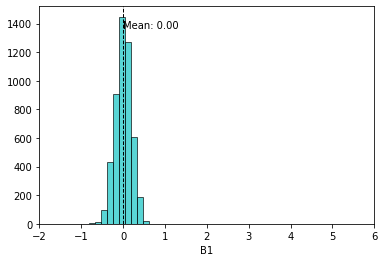

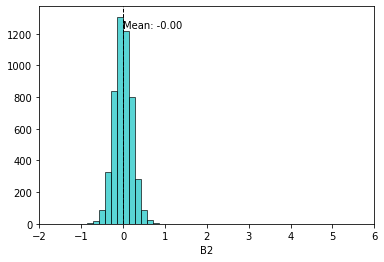

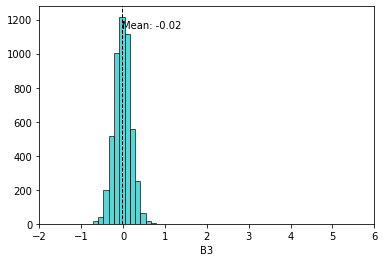

In [14]:
plot_hist(b1, 'B1', -2, 6)
plot_hist(b2, 'B2', -2, 6)
plot_hist(b3, 'B3', -2, 6)

## Performing 5,000 experiments

With the same predictor variables, we peform 5000 experiments and hence obtain 5000 estimators.


In [ ]:
b1 = []
b2 = []
b3 = []
for _ in range(5000):    

    yi = np.random.binomial(1, pi) # One trial
    beta_1, _, _, _ = newton_n_iter(xArr, yi, [0, 0, 0])
    
    b1.append(beta_1[0])
    b2.append(beta_1[1])
    b3.append(beta_1[2])

In [ ]:
def plot_hist(x, name, left, right):
    if type(x).__name__ == 'list':
        x = np.array(x)
        
    plt.hist(x, bins=12, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))
    plt.xlabel(name); plt.xlim(left,right); 
    plt.show()

In [ ]:
plot_hist(b1, 'B1', -2, 6)
plot_hist(b2, 'B2', -2, 6)
plot_hist(b3, 'B3', -2, 6)